In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

## How to plot the guessing confidence?

In [52]:
init = 'dense'
intervention = 'effect'
k = 20
results_dir = 'results'
file =f'guess_{init}init_{intervention}_k={k}.pkl'
with open(os.path.join(results_dir, file), 'rb') as fin:
    results = pickle.load(fin)

In [53]:
for e in results:
    print(e['lr'])
    if e['lr']==3:
        exp =e

0.03
0.1
0.3
1
3
9
30


We guess the intervention took place on the variable with the lowest likelihood, so here this is correct

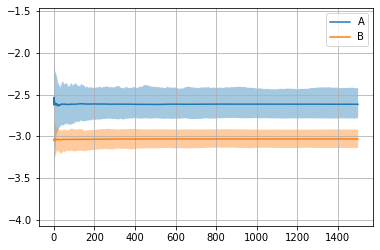

In [54]:
for whom in ['A','B']:
    like = exp['loglikelihood'+whom][:].cumsum(0)
    xx = np.arange(1, like.shape[0]+1)
    like /= xx[:,np.newaxis]
    plt.plot(like.mean(1), label = whom)
    plt.fill_between(
            xx,
            np.percentile(like, 5, axis=1),
            np.percentile(like, 95, axis=1),
            alpha=.4
    )    
plt.grid()
plt.legend()

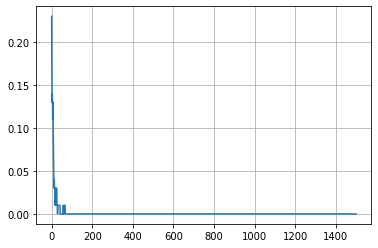

In [55]:
values = {}
for whom in ['A','B']:
    values[whom] = exp['loglikelihood'+whom][:].cumsum(0)
    xx = np.arange(1, values[whom].shape[0]+1)
    values[whom] /= xx[:,np.newaxis]

values['guessright'] = (values['A'] < values['B']).astype(float)

plt.plot(values['guessright'].mean(1)) 
plt.grid()

(-1, 1)

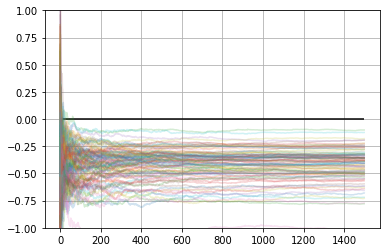

In [57]:
plt.plot(values['B'] - values['A'], alpha=.2)
plt.hlines(0,0, values['B'].shape[0])
plt.grid()
plt.ylim(-1,1 )

In [70]:
def guess_trajectories(init, intervention, k):
    results_dir = 'results'
    file =f'guess_{init}init_{intervention}_k={k}.pkl'
    with open(os.path.join(results_dir, file), 'rb') as fin:
        results = pickle.load(fin)
        
    exp = results[0]
    values = {}
    for whom in ['A','B']:
        values[whom] = exp['loglikelihood'+whom][:k**2//4].cumsum(0)
        xx = np.arange(1, values[whom].shape[0]+1)
        values[whom] /= xx[:,np.newaxis]

    if intervention=='cause':
        right, wrong = 'A', 'B'
    else:
        right, wrong = 'B', 'A'
    
    print(values[right].shape)
    plt.plot(values[wrong] - values[right], alpha=.2)
    plt.hlines(0,0, values['B'].shape[0])
    plt.grid()
    plt.ylim(-1,1 )
    plt.title(f'{init} {intervention} k={k}')
    plt.show()

(25, 100)


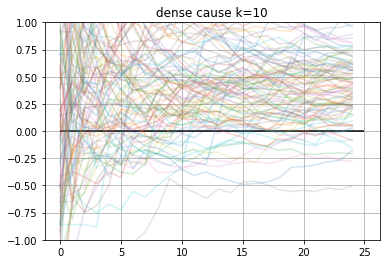

(25, 100)


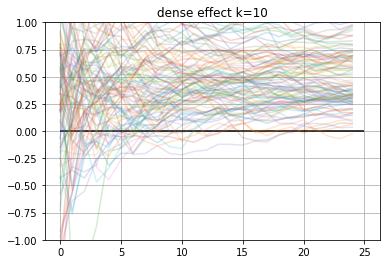

(25, 100)


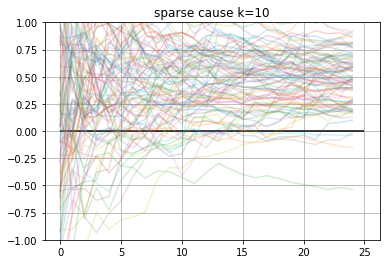

(25, 100)


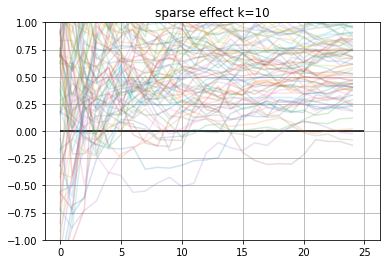

(100, 100)


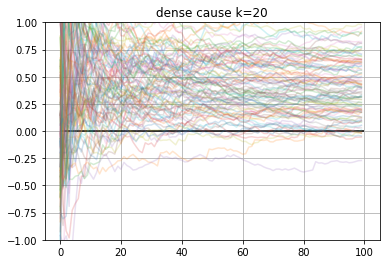

(100, 100)


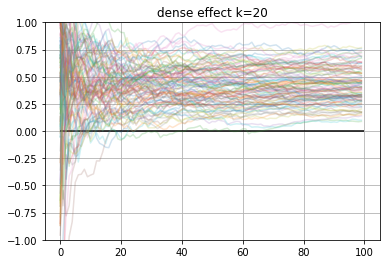

(100, 100)


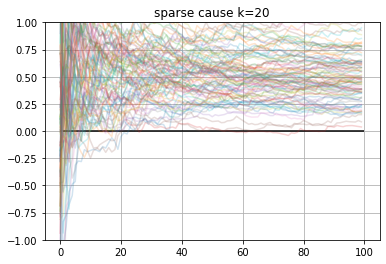

(100, 100)


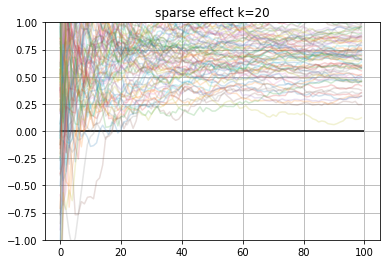

(625, 100)


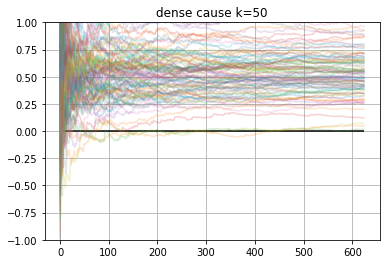

(625, 100)


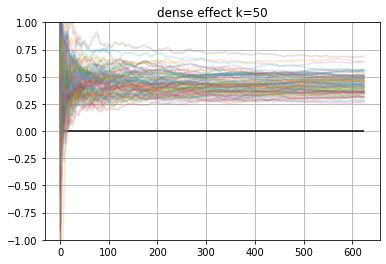

(625, 100)


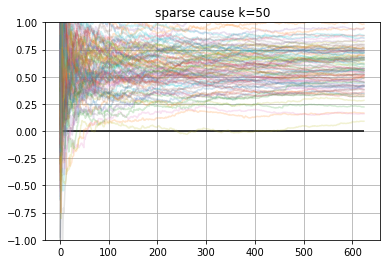

(625, 100)


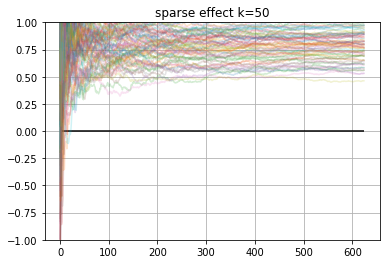

In [71]:
init = 'dense'
intervention = 'effect'
for k in [10, 20, 50]:
    for init in ['dense','sparse']:
        for intervention in ['cause', 'effect']:
            guess_trajectories(init, intervention, k)

# Geometric intervention
Why does the geometric intervention seem super hard to optimize ? Investigate the property of this mean of logits.

In [5]:
from categorical.distances1 import sample_joint
from categorical.utils import entropy, kullback_leibler

In [7]:
k = 50
causal = sample_joint(k=k, n=100,concentration=1)

In [8]:
geometric = causal.intervention(on='geometric')
weigthedgeo = causal.intervention(on='weightedgeo')

In [9]:
uniform = np.ones(k)/k
for marg in [
    causal.marginal,
    causal.reverse().marginal,
    geometric.reverse().marginal,
    weigthedgeo.reverse().marginal
]:
    hh = np.log(kullback_leibler(uniform, marg))
    print(hh.mean(),hh.std())


-0.5856104952437543 0.20110233245465112
-0.6955424650792924 0.19270562088852874
2.3862346614533196 0.1779050986356653
2.709524084827614 0.17875532461521174


The effect marginal is closer from uniform, and the geometric intervention is even closer.
On contrary the weighted geometic intervention is less close from the uniform.
The difficulty of optimizing for geometric intervention might be due to this uniformity. Converging to the center of the simplex is more difficult than converging to one of the sides which is effectively lower dimensional. Except that the KL explodes in these situations. This may also explain why the expected KL is 0.5 after geometric intervention vs 1 after other interventions. 

# What is the effect marginal like for different initializations ?

In [10]:
from categorical.distances1 import sample_joint, CategoricalStatic

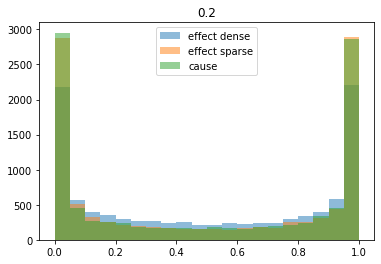

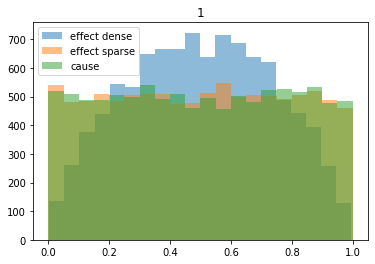

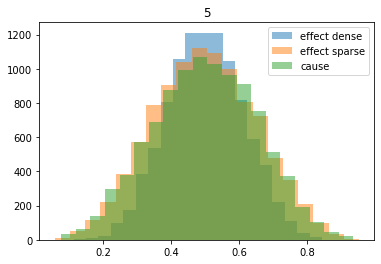

In [28]:
n=10000
k=2
for concentration in [.2,1,5]:
    plt.figure()
    for sym in [True, False]:
        p = sample_joint(k, n, concentration, dense=sym, logits=False)
        q = p.reverse().marginal[:,0]
        plt.hist(q, bins=20,alpha=.5, label='effect '+('dense' if sym else 'sparse'))
    plt.hist(p.marginal[:,0], bins=20,alpha=.5, label='cause')
    plt.title(concentration)
    plt.legend()
    plt.show()
    pass

## check determinant of change of variable from joint to conditional

In [ ]:
import math
import torch
import hessian
from hessian import jacobian

In [ ]:
def joint2cond(joint):
    # joint is missing it's latest dimension
    k = int(math.sqrt(joint.shape[0]+1))
    full = torch.zeros(k*k)
    full[:-1] = joint
    full[-1] = 1 - torch.sum(joint)
    full = full.view(k,k)
    pa = torch.sum(full,dim=1).contiguous()
    pab = (full / pa[:,None]).contiguous()
    return pa[:-1], pab[:,:-1].flatten(), pa, pab


# sanity check
k =3
joint = torch.softmax(torch.randn(size=(k*k,)), dim=0)[:-1]
joint.requires_grad = True
pa, pab, pafull, _ = joint2cond(joint)
print(joint, pa, pab)
# assert torch.allclose(joint.sum(),torch.ones(1))
# assert torch.allclose(pa.sum(), torch.ones(1))
# assert torch.allclose(pab.sum(1), torch.ones(k))
# assert torch.allclose(joint, pab *pa[:,None])

jacob = jacobian([pa,pab], joint)
print(jacob)
print(torch.logdet(jacob), (1-k) * torch.sum(torch.log(pafull)))

for k in range(2,10):
    joint = torch.softmax(torch.randn(size=(k*k,)), dim=0)[:-1]
    joint.requires_grad = True
    pa, pab, pafull, _ = joint2cond(joint)
    jacob = jacobian([pa,pab], joint)
    print(k, (1-k) * torch.sum(torch.log(pafull.detach())).item())
    assert torch.allclose(torch.slogdet(jacob)[1], (1-k) * torch.sum(torch.log(pafull)))

# Analysis of chalupka with the modified sampling rule
The log likelihood ratio is now 1, both distributions are the same

$$\sqrt{R} = \frac{(d+f)(1 - d - f)}{(d+e)(1 -d -e)}$$

In [20]:
def loglikelihoodratio(d,e,f):
    px1 = d+e
    varx = px1*(1-px1)
    py1 = d+f
    vary = py1 *(1-py1)
    return np.where(d+e+f >1, np.nan, np.log(vary) - np.log(varx))

def causal_likelihood(d,e,f):
    px1 = d+e
    varx = px1*(1-px1)
    g = 1- d - e -f
    return np.where(g<0, np.nan, .5*sum([np.log(i) for i in [d,e,f,g]]) - 2*np.log(varx))

In [21]:
xx = np.linspace(0.01,.99,20)
d,e,f = np.meshgrid(xx,xx,xx,indexing='ij')

In [22]:
r = loglikelihoodratio(d,e,f)[:-2]
#r = causal_likelihood(d,e,f)
# g = 1- d - e -f
# r = np.where(g<0, np.nan, d*e*f*g)

/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [23]:
print(np.isnan(r).sum(), np.isinf(r).sum())

5871 0


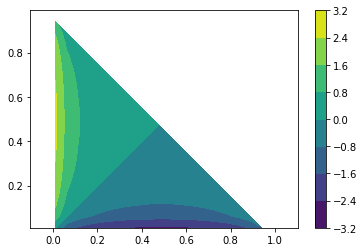

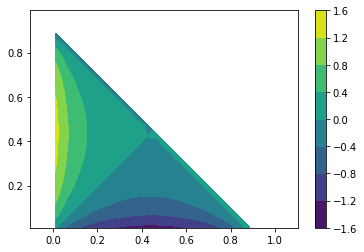

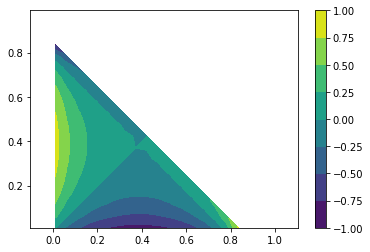

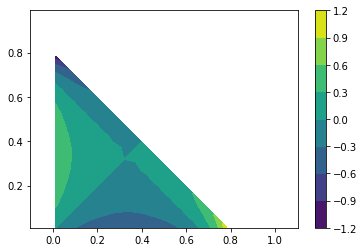

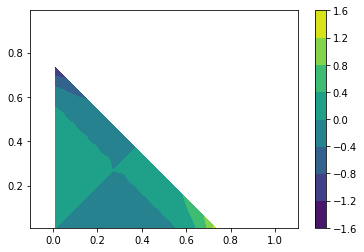

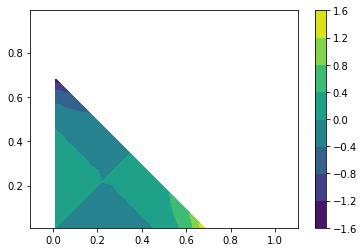

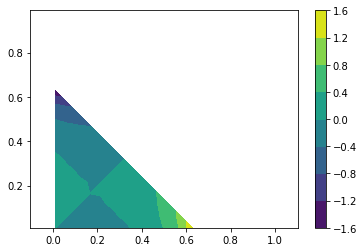

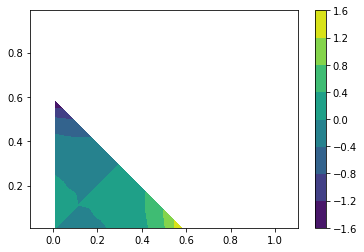

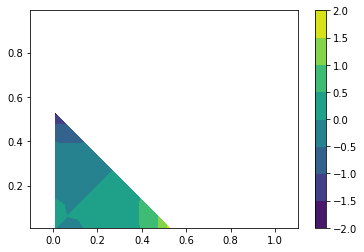

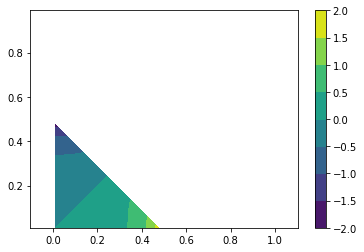

In [24]:
for i in range(min(r.shape[0],10)):
    plt.figure()
    plt.contourf(e[i], f[i], r[i], cmap='viridis')
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    

The classifier i got is the same as with their other assumption on the meta-prior. Now let's estimate the error rate of this likelihood ratio method under my hypothesis. Under their hypothesis, it was 0.4. I am basically estimating the overlap of distributions.

In [26]:
n = 10000
for conditional_prior in [(1,1),(.5,.5)]:
    a = np.random.beta(1,1, size=n)
    b = np.random.beta(*conditional_prior, size=n)
    c = np.random.beta(*conditional_prior, size=n)
    d, e, f = a*b, a*(1-b), (1-a)*c
    print((loglikelihoodratio(d,e,f)<0).mean(), np.mean(np.random.uniform(size=n)>.5))

0.3925 0.5058
0.5036 0.4932


I got some the dirchlet regularization wrong. In truth using a sparse prior makes both directions indistinguishible. Now I am going to scale the result of chalupka thanks to the jacobian formula. The optimal classifier simply compares the sum of log(p(X)) and sum log(p(Y)).

In [60]:
ans

defaultdict(list,
            {'k': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
             'error': [0.386446,
              0.241216,
              0.133671,
              0.067115,
              0.031005,
              0.01311,
              0.005224,
              0.002035,
              0.000702,
              0.00025,
              6.7e-05,
              2.6e-05,
              4e-06]})

In [61]:
for key in ans:
    tmp = [key] + [str(i) if type(i)==int else f'{i:.1g}'.strip('0') for i in ans[key]]
    print(' & '.join(tmp), '\\\\')

k & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\
error & .4 & .2 & .1 & .07 & .03 & .01 & .005 & .002 & .0007 & .0003 & 7e-05 & 3e-05 & 4e-06 \\


## Softargmax(loggamma vs gaussian)
Problem: the loggamma from scipy samples by explicitly taking the log of the gamma variable from the same scipy. It means that it's not numerically stable for low values of the shape parameter. I need to understand the behvaior of the loggamma distribution based on the shape parameter.

In [ ]:
from categorical.utils import logit2proba
from scipy import stats

In [ ]:
k=10
logitsgamma = stats.loggamma.rvs(c=1/k, size=(10,k))
pgamma = logit2proba(logitsgamma)
#no simple way to check whether this is the dirichlet I want
pgamma[0]

In [ ]:
xx = np.linspace(-500, 10, 1000)
xx2 = np.linspace(0, 1, 1000)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
for k in range(1,4,1):
    c = k/100
    law = stats.loggamma(c)
    m = law.mean()
    v = law.var()
    # approx = stats.norm(m,np.sqrt(v))
    approx = stats.expon(scale=1/c)
    color = next(ax1._get_lines.prop_cycler)['color']
    print(f'law {c:.2f} \t mean {m:.2f} \t var {v:.2f} \t {color}')
    ax1.plot(xx, law.pdf(xx), color=color, label=f'c={c:.2f}', alpha=.5)
    ax1.plot(xx, approx.pdf(-xx), color=color, linestyle=':')
    ax2.plot(xx2, law.ppf(xx2))
    
ax1.set_title('density function')
# ax1.set_ylim(-40,0)
ax1.legend()
ax1.grid()
ax2.set_title('inverse cumulative function')
ax2.grid()

Use the inverse transform sampling method to get samples of a log gamma with very small shape parameter

In [ ]:
n = 1000
c = 1/1000
law = stats.loggamma(c)

# inverse transform samples
uu = np.random.rand(n)
samples = law.ppf(uu)
samples = samples[np.invert(np.isinf(samples))]
plt.hist(samples, bins=20, density=True)

# scipy sampling
samples2 = law.rvs(size=1000)
samples2 = samples2[np.invert(np.isinf(samples2))]
plt.hist(samples2, bins=20, density=True, alpha=.5)

# exponential sampling
expon = stats.expon(scale=1/c)
samples3 = - expon.rvs( size=n)
plt.hist(samples3, bins=20, density=True, alpha=.5)

# density plot
xx = np.linspace(np.nanmin(samples3),2, 1000)
plt.plot(xx, law.pdf(xx))
plt.plot(xx, expon.pdf(-xx))

print(len(samples), len(samples2), len(samples3))
pass

In [1]:
errors = {'k': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
         'error': [0.386446,
          0.241216,
          0.133671,
          0.067115,
          0.031005,
          0.01311,
          0.005224,
          0.002035,
          0.000702,
          0.00025,
          6.7e-05,
          2.6e-05,
          4e-06]}

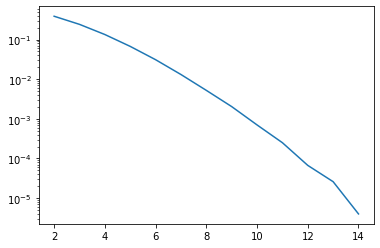

In [3]:
plt.semilogy(errors['k'], errors['error'])